##### Data - Loader

In [1]:
import torch
import cv2
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

# This was needed for getting rid of from the errors that come out from "plt" errors
os.environ['KMP_DUPLICATE_LIB_OK']='True'

print("Cuda Avaliable :", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#torch.util.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=None, pin_memory=False)

# Ask Valeh how can it be written in a much better way !!!

class CaltechDataset (torch.utils.data.Dataset):
    def __init__(self, root, resize_dim, train = False):
       
        self.root = root
        
        if train:
            self.imgs = sorted(os.listdir(os.path.join(root, "101_ObjectCategories/airplanes")))[0:640]
            self.annotations = sorted(os.listdir(os.path.join(root, "Annotations/Airplanes_Side_2")))[0:640]
        else:
            self.imgs = sorted(os.listdir(os.path.join(root, "101_ObjectCategories/airplanes")))[640:]
            self.annotations = sorted(os.listdir(os.path.join(root, "Annotations/Airplanes_Side_2")))[640:]
       
        self.dim = resize_dim
       
    def __getitem__(self, idx):
       
        image_path = os.path.join(self.root, "101_ObjectCategories/airplanes/", self.imgs[idx])
        annotation_path = os.path.join(self.root, "Annotations/Airplanes_Side_2/", self.annotations[idx])
       
        img = cv2.imread(image_path)
       
        h, w, _ = img.shape
       
        img = cv2.resize(img, (self.dim, self.dim), interpolation = cv2.INTER_AREA)
       
        annot = scipy.io.loadmat(annotation_path)["box_coord"][0]
       
        top_left_x, top_left_y = annot[2], annot[0]
        bottom_rigth_x, bottom_right_y = annot[3], annot[1]
       
        target = (float(top_left_x)/w, float(top_left_y)/h, float(bottom_rigth_x)/w, float(bottom_right_y)/h)
        
        target = torch.as_tensor(target)
        target = target.to(device)
        #target = torch.as_tensor(target).to(device)
        img = torch.as_tensor(img)
        img = img.to(device)
       
        return img, target
       
    def __len__(self):
        return len(self.imgs)

Cuda Avaliable : True
cuda


##### Split Data into train and test sets

In [2]:
# Train Set :

dataset = CaltechDataset("caltech-101/", resize_dim = 224, train=True)
train_dataset = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=None, pin_memory=False)

# Test Set :

dataset = CaltechDataset("caltech-101/", resize_dim = 224, train=False)
test_dataset = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=None, pin_memory=False)

#Data = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=None, pin_memory=False)

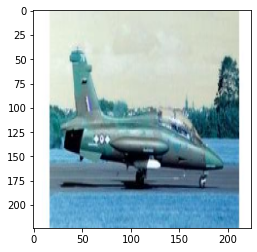

In [3]:
image = next(iter(train_dataset))[0][0]
plt.imshow(image.cpu())

##### Add Patch Layer

In [4]:
class PatchesCreate(torch.nn.Module):
    def __init__(self, patch_size):
        super(PatchesCreate, self).__init__()
        self.patch_size = patch_size
        
    def forward(self, images):
        
        batch_size = images.shape[0]
        image_size = images.shape[1]
        grid_size = int(image_size/self.patch_size)
        
        Patches_Mask = torch.zeros(batch_size, grid_size, grid_size, self.patch_size**2*3)
        
        for index, image in enumerate(images):
            for i in range(grid_size):
                for j in range(grid_size):
                    patch_image = image[i*self.patch_size:(i+1)*self.patch_size, j*self.patch_size:(j+1)*self.patch_size, :]
                    Patches_Mask[index, i, j, : ] = torch.flatten(patch_image)
                    Patches = torch.reshape(Patches_Mask, (batch_size, -1, self.patch_size**2*3))
                    
        #Patches = Patches.to(device)
        return Patches

##### Lets Check Patches

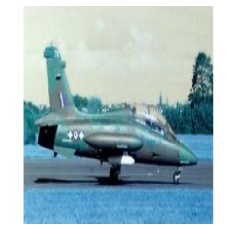

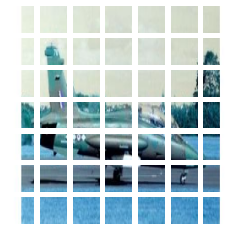

In [5]:
Patchlayer = PatchesCreate(32)
Patches = Patchlayer.forward(next(iter(train_dataset))[0])

plt.figure(figsize=(4, 4))

plt.imshow(next(iter(train_dataset))[0][0].cpu())

plt.axis("off")

Patches = Patchlayer.forward(next(iter(train_dataset))[0])

num_patches = Patches[0].shape[0]

plt.figure(figsize=(4, 4))

for i in range(num_patches):
    
    patch_img = torch.reshape(Patches[0][i], (32,32,3))
    
    patch_img = np.array(patch_img.cpu())
    
    ax = plt.subplot(7, 7, i + 1)
    
    plt.imshow((patch_img.astype("uint8")))
    plt.axis("off")

##### Encode Patches

In [6]:
class EncodePatches(torch.nn.Module):
    def __init__(self, num_patches, project_dim, patch_dim):
        
        ##Interesting !!! it has worked like this but discuss that with Valeh definitely before it became too late
        super(EncodePatches, self).__init__()
        self.num_patches = num_patches
        self.project_dim = project_dim
        self.patch_dim = patch_dim
        self.project = torch.nn.Linear(patch_dim, project_dim)
        self.positioning = torch.nn.Embedding(num_patches, project_dim)
    
    def forward(self, patch):
        
        
        
        #positions = torch.range(start = 0, end = self.num_patches - 1, step = 1)
        positions = torch.arange(self.num_patches)
        #EncodedPatches = self.project(patch) + self.positioning(positions)
        positions = positions.to(device)
        patch = patch.to(device)
        EncodedPatches = torch.add(self.project(patch), self.positioning(positions))
        #EncodedPatches = self.project(patch)
        return EncodedPatches

##### MLP for transformer block

In [7]:
class MultiLayerPerceptronForTransformerBlock(torch.nn.Module):
    def __init__(self, project_dim):
        super(MultiLayerPerceptronForTransformerBlock, self).__init__()
        self.project_dim = project_dim
        self.FirstHiddenLayer = torch.nn.Linear(project_dim, project_dim*2)
        self.SecondHiddenLayer = torch.nn.Linear(project_dim*2, project_dim)
        self.ActivationFunction = torch.nn.GELU()
        self.DropOut = torch.nn.Dropout(p = 0.1)
        
    def forward(self, x):
        
        x = self.FirstHiddenLayer(x)
        x = self.ActivationFunction(x)
        x = self.DropOut(x)
        x = self.SecondHiddenLayer(x)
        x = self.ActivationFunction(x)
        x = self.DropOut(x)
        
        return x
    

##### Transformer Block

In [8]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, num_heads, project_dim, num_patches ):
        super(TransformerBlock, self).__init__()
        self.num_heads, self.project_dim, self.num_patches = num_heads, project_dim, num_patches
        self.Normalization_1 = torch.nn.LayerNorm(project_dim, eps=1e-06)
        self.Attention = torch.nn.MultiheadAttention(embed_dim = project_dim, num_heads = num_heads, dropout = 0.1, batch_first=True)
        self.TransfomerMLP = MultiLayerPerceptronForTransformerBlock(project_dim)
        self.Normalization_2 = torch.nn.LayerNorm(project_dim, eps=1e-06)
            
        
    def forward(self, encoded_patches):
        x1 = self.Normalization_1(encoded_patches)
        attention_out, attention_weights = self.Attention(x1, x1, x1, average_attn_weights=True)
        x2 = torch.add(attention_out, encoded_patches)
        x3 = self.Normalization_2(x2)
        x3 = self.TransfomerMLP(x3)
        
        encoded_patches = torch.add(x3, x2)
        
        return encoded_patches

##### MLP for Head

In [9]:
class MultiLayerPerceptronForHead(torch.nn.Module):
    def __init__(self, num_patches, project_dim):
        super(MultiLayerPerceptronForHead, self).__init__()
        self.num_patches, self.project_dim = num_patches, project_dim
        self.FirstHiddenLayer = torch.nn.Linear(num_patches*project_dim, 2048)
        self.SecondHiddenLayer = torch.nn.Linear(2048, 1024)
        self.ThirdHiddenLayer = torch.nn.Linear(1024, 512)
        self.ForthHiddenLayer = torch.nn.Linear(512, 64)
        self.FifthHiddenLayer = torch.nn.Linear(64, 32)
        self.ActivationFunction = torch.nn.GELU()
        self.DropOut = torch.nn.Dropout(p = 0.3)
        
    def forward(self, x):
        
        x = self.FirstHiddenLayer(x)
        x = self.ActivationFunction(x)
        x = self.DropOut(x)
        x = self.SecondHiddenLayer(x)
        x = self.ActivationFunction(x)
        x = self.DropOut(x)
        x = self.ThirdHiddenLayer(x)
        x = self.ActivationFunction(x)
        x = self.DropOut(x)
        x = self.ForthHiddenLayer(x)
        x = self.ActivationFunction(x)
        x = self.DropOut(x)
        x = self.FifthHiddenLayer(x)
        x = self.ActivationFunction(x)
        x = self.DropOut(x)
        
        return x

###### Vision - TRANSFORMER MODEL

In [10]:
class VitModel(torch.nn.Module):
    def __init__(self, patch_size, num_patches, project_dim, num_heads):
        super(VitModel, self).__init__()
        
        self.PacthesCreate = PatchesCreate(patch_size)
        self.EncodePatches = EncodePatches(num_patches, project_dim, patch_size**2*3)
        self.TB_1 = TransformerBlock(num_heads, project_dim, num_patches)
        self.TB_2 = TransformerBlock(num_heads, project_dim, num_patches)
        self.TB_3 = TransformerBlock(num_heads, project_dim, num_patches)
        self.TB_4 = TransformerBlock(num_heads, project_dim, num_patches)
        self.Normalization = torch.nn.LayerNorm(project_dim, eps=1e-06)
        self.MPH = MultiLayerPerceptronForHead(num_patches, project_dim)
        self.DropOut = torch.nn.Dropout(p = 0.3)
        self.bounding_box = torch.nn.Linear(patch_size, 4)
        
    def forward(self, inputs):
        
        patches = self.PacthesCreate(inputs)
        
        encoded_patches = self.EncodePatches(patches)
        
        # Four transformer block (Can it be written in a better way ask to Valeh!!!)
        encoded_patches = self.TB_1(encoded_patches)
        encoded_patches = self.TB_2(encoded_patches)
        encoded_patches = self.TB_3(encoded_patches)
        encoded_patches = self.TB_4(encoded_patches)
        
        # Head
        representation = self.Normalization(encoded_patches)
        representation = torch.flatten(representation, start_dim = 1)
        representation = self.DropOut(representation)
        # MLP
        features = self.MPH(representation)
        
        # Neurons that output Bounding Box
        bounding_box = self.bounding_box(features)
        
        return bounding_box

In [11]:
model = VitModel(patch_size = 32, num_patches = 49, project_dim = 64, num_heads = 4)

In [12]:
model = model.to(device)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_loss = 0.0
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = train_loss + loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print("Train loss :", train_loss)
            
def test_loop(dataloader, model, loss_fn):
    test_loss = 0.0
    
    for batch, (X,y) in enumerate(dataloader):
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        test_loss = test_loss + loss.item()
    
    print("Test loss :", test_loss)
        
            
# Define Hyperparameters :

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
            
            
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [14]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataset, model, loss_fn, optimizer)
    test_loop(test_dataset, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.292239  [    0/  640]
loss: 0.087548  [  100/  640]
loss: 0.037025  [  200/  640]
loss: 0.010608  [  300/  640]
loss: 0.013018  [  400/  640]
loss: 0.006682  [  500/  640]
loss: 0.003143  [  600/  640]
Train loss : 29.09163514134707
Test loss : 1.2985174055793323
Epoch 2
-------------------------------
loss: 0.006627  [    0/  640]
loss: 0.015894  [  100/  640]
loss: 0.004176  [  200/  640]
loss: 0.003335  [  300/  640]
loss: 0.006842  [  400/  640]
loss: 0.001614  [  500/  640]
loss: 0.004396  [  600/  640]
Train loss : 4.487131323585345
Test loss : 0.8341199801507173
Epoch 3
-------------------------------
loss: 0.008804  [    0/  640]
loss: 0.006566  [  100/  640]
loss: 0.001763  [  200/  640]
loss: 0.005366  [  300/  640]
loss: 0.001033  [  400/  640]
loss: 0.001258  [  500/  640]
loss: 0.000813  [  600/  640]
Train loss : 3.2981718913215445
Test loss : 0.9589629907568451
Epoch 4
-------------------------------
loss: 0.018801  [    0/

loss: 0.007030  [  100/  640]
loss: 0.000530  [  200/  640]
loss: 0.000690  [  300/  640]
loss: 0.000072  [  400/  640]
loss: 0.000842  [  500/  640]
loss: 0.000094  [  600/  640]
Train loss : 0.8908308091108665
Test loss : 0.11018177880214353
Epoch 28
-------------------------------
loss: 0.000922  [    0/  640]
loss: 0.007901  [  100/  640]
loss: 0.000371  [  200/  640]
loss: 0.000898  [  300/  640]
loss: 0.000088  [  400/  640]
loss: 0.001029  [  500/  640]
loss: 0.000094  [  600/  640]
Train loss : 0.9006075221859646
Test loss : 0.10947661309546675
Epoch 29
-------------------------------
loss: 0.000963  [    0/  640]
loss: 0.006746  [  100/  640]
loss: 0.000495  [  200/  640]
loss: 0.000825  [  300/  640]
loss: 0.000086  [  400/  640]
loss: 0.000959  [  500/  640]
loss: 0.000085  [  600/  640]
Train loss : 0.8988413918177685
Test loss : 0.11367536699617631
Epoch 30
-------------------------------
loss: 0.001036  [    0/  640]
loss: 0.007216  [  100/  640]
loss: 0.000464  [  200/  

In [15]:
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )

In [16]:
# Lets try on test images :

Test_Dataset = CaltechDataset("caltech-101/", resize_dim = 224, train=False)

mean_iou: 0.8921865993594125


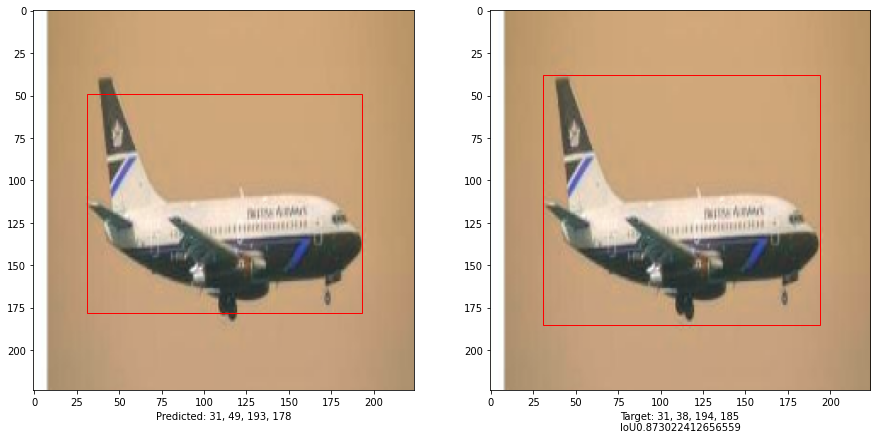

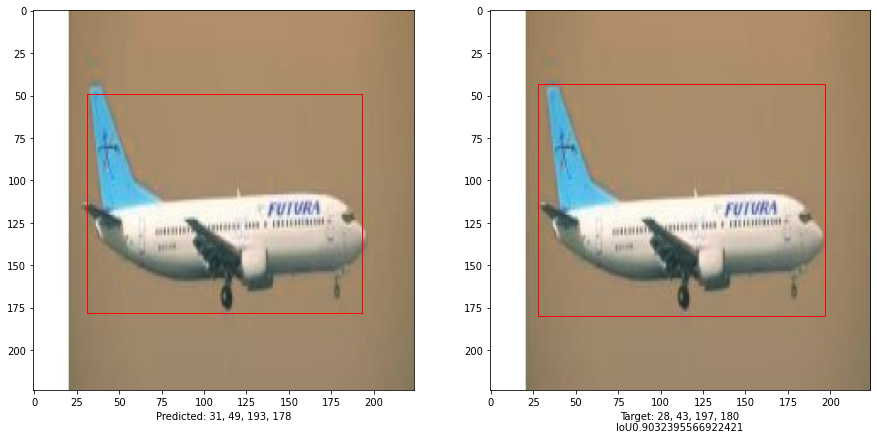

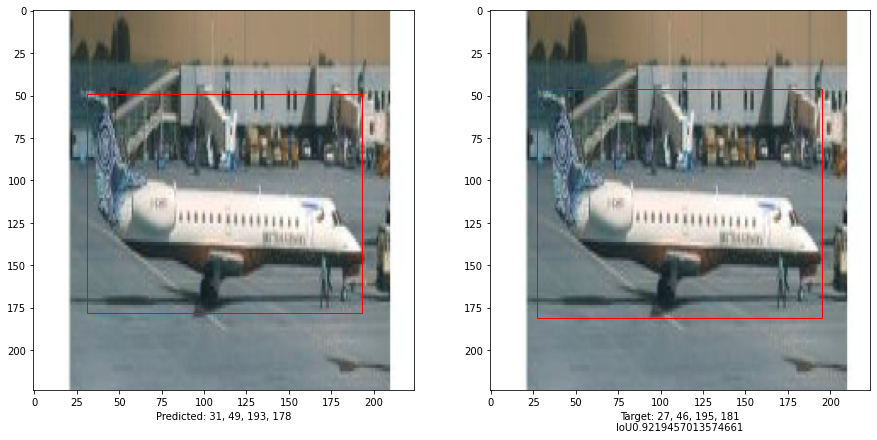

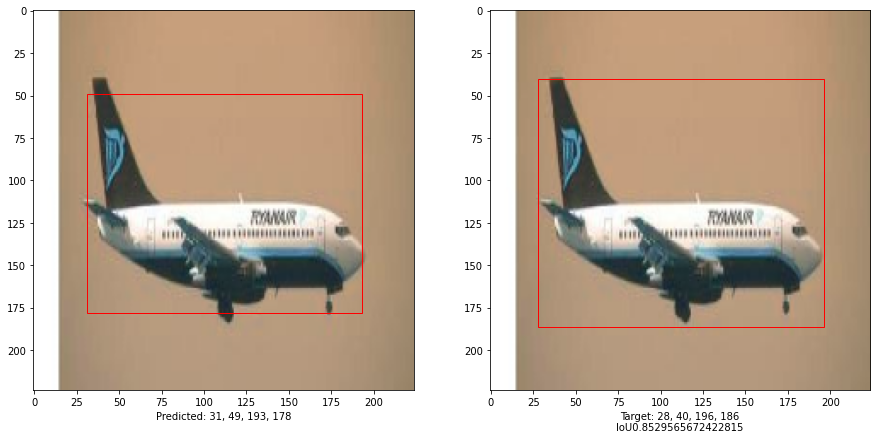

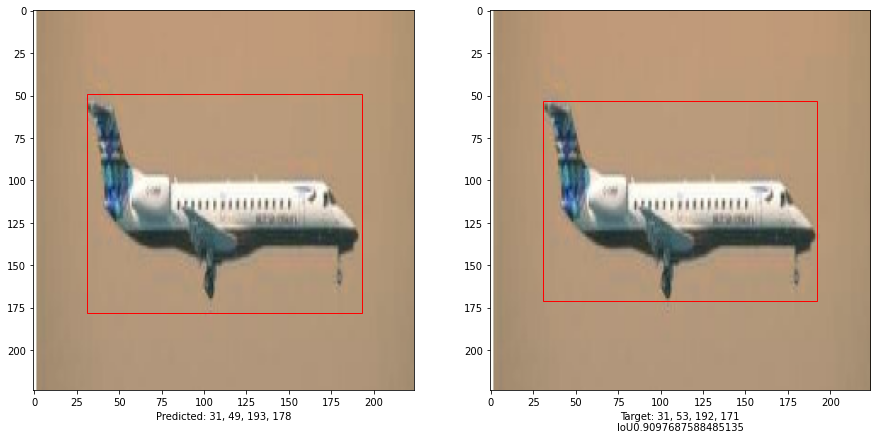

In [17]:
import matplotlib.patches as patches

mean_iou = 0.0

n_test = 5

# Compare results for 3 images in the test set
for i in range(n_test):
    #print(Test_Dataset[i][0])
    #input_image = Test_Dataset[i][0]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = Test_Dataset[i][0].cpu().numpy()
    
    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))
    
    # Prediction from trained model
    im = np.expand_dims(im, axis=0)
    input_image = torch.tensor(im).cuda()
    preds = model(input_image)[0]
    
    (h, w) = (im).shape[1:3]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)
    
    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )
    
    box_coord = Test_Dataset[i][1]
    
    top_left_x, top_left_y = int(box_coord[0] * w), int(box_coord[1] * h)

    bottom_right_x, bottom_right_y = int(box_coord[2] * w), int(box_coord[3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    
print("mean_iou: " + str(mean_iou / n_test))    
plt.show()

##### Save Model

In [18]:
#torch.save(model.state_dict(), 'Vision_Transformer.pth')

In [19]:
#model = torch.load('Vision_Transformer.pth')

###### Things needs to be done :
* Add testing function for evaluation during training. -- completed !!!
* Add prediction visualization. -- completed !!!
* Add GPU Support -- completed !!!
* In our dataloader function we are already resizing the images so just fastly check that how can we do better from engineering side